In [24]:
import os
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import collections
import re
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation  
from string import digits
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# use if required
#!pip install contractions
import contractions
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
# Use only when using colab to mount the drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
#Preprocessing
#Use these if required.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# create a lemmatizer object
lemmatizer = nltk.stem.WordNetLemmatizer()
# create an object to remove punctuation marks
puncutation_translator = str.maketrans('', '', punctuation)
digit_translator = str.maketrans('', '', digits)
# create a stop word list (*** Check if negation words need to be eliminated from the list ***)
stopwords_list = set(stopwords.words('english') + list(punctuation) + ['ATUSER','URL'])

## function for pre-preocessing individual tweet
## 1. Changing it into lowercase
## 2. Fixing contractions. For e.g. can't -> can not
## 3. Removing URLs
## 4. Removing usernames.
## 5. Removing Punctutation marks.
## 6. Removing digits.
## 7. Tokenizing sentences into words.
## 8. Lemmatization of each word assuming it's POS tag as verb.
## 9. Removing stop words.
def preProcessTweet(tweet_elm):
  tweet = tweet_elm.lower()
  tweet = contractions.fix(tweet)
  tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet)
  tweet = re.sub('@[^\s]+', 'ATUSER', tweet)
  tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
  tweet = tweet.translate(puncutation_translator)
  tweet = tweet.translate(digit_translator)
  tweet = word_tokenize(tweet)
  return " ".join([lemmatizer.lemmatize(word, 'v') for word in tweet if word not in stopwords_list])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# extract vaccine dataset
dataFrame_vaccine_trend = pd.read_csv("/content/drive/My Drive/study/data_analytics/project/src/covid_data/vaccine_tweets_jan_2021.csv", encoding = "utf8") 
dataFrame_vaccine_trend.head()

,date,tweet
0,2021-01-01 00:00:00+00:00,The distribution of the COVID-19 vaccine will ...
1,2021-01-01 00:00:00+00:00,COVID-19 Vaccine Rollout Is Way Behind Schedul...
2,2021-01-01 00:00:00+00:00,The Hamilton County Health Department was forc...
3,2021-01-01 00:00:00+00:00,So we've entered 2021. 2020 has been very bad ...
4,2021-01-01 00:00:01+00:00,Covid vaccines are rolling out &amp; hope is o...


In [7]:
# extract sentiment ratings and tweets
tweet_date_time = dataFrame_vaccine_trend.iloc[:, 0].to_numpy()
tweets_vaccine = dataFrame_vaccine_trend.iloc[:, 1].to_numpy()

In [11]:
# Process dates
tweet_date = []
for date_time in tweet_date_time:
  tweet_date.append(date_time.split(" ")[0])

dates_dict = collections.Counter(tweet_date)
unique_dates = list(dates_dict.keys())

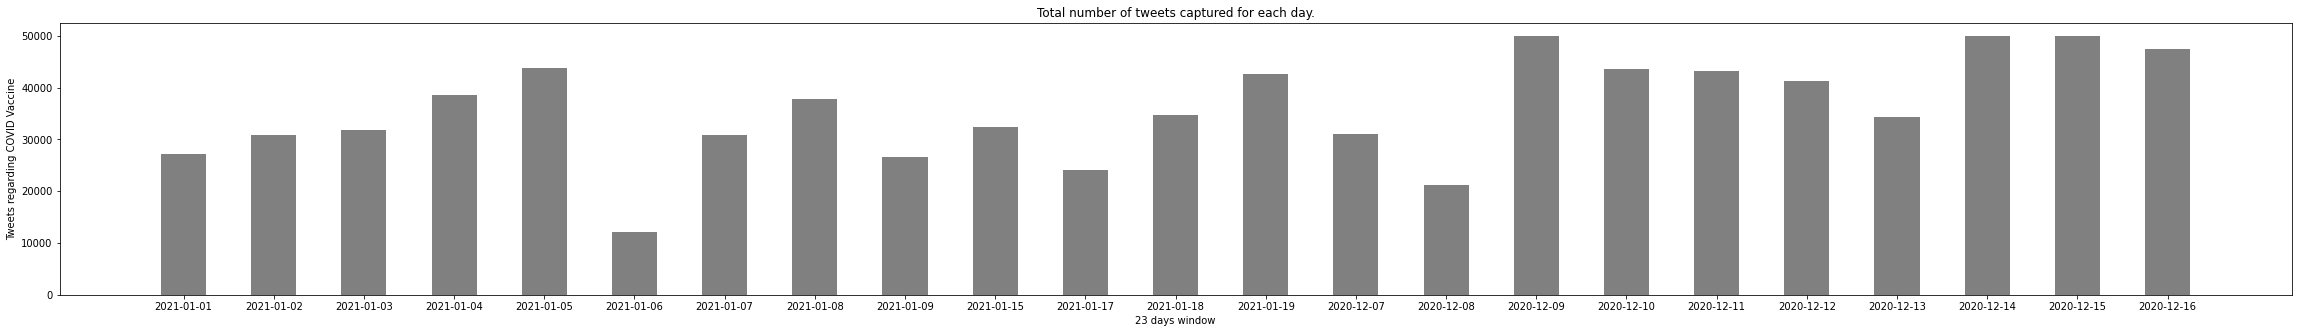

In [13]:
fig = plt.figure(figsize = (40, 5))

# creating the bar plot
plt.bar(list(dates_dict.keys()), list(dates_dict.values()), color ='grey', width = 0.5)
 
plt.xlabel(str(len(unique_dates)) + " days window")
plt.ylabel("Tweets regarding COVID Vaccine")
plt.title("Total number of tweets captured for each day.")
plt.show()

In [14]:
# Process tweets
processed_tweets_vaccine = []
for tweet in tweets_vaccine:
  processed_tweets_vaccine.append(preProcessTweet(tweet))

In [16]:
## VADER Analysis
!pip install twython
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [17]:
# Vader Analyzer oObject
vaderSentimentAnalyzer = SentimentIntensityAnalyzer()

tweet_sentiment_vader = []
neg_sentiment = 0
pos_sentiment = 0
neu_sentiment = 0

for tweet in tweets_vaccine:#processed_tweets_vaccine:
  score = vaderSentimentAnalyzer.polarity_scores(tweet)
  sentiment = score['compound']
  
  if (sentiment < 0):
    neg_sentiment += 1
    tweet_sentiment_vader.append("negative")
  elif (sentiment > 0):
    pos_sentiment += 1
    tweet_sentiment_vader.append("positive")
  elif (sentiment == 0):
    neu_sentiment += 1
    tweet_sentiment_vader.append("neutral")

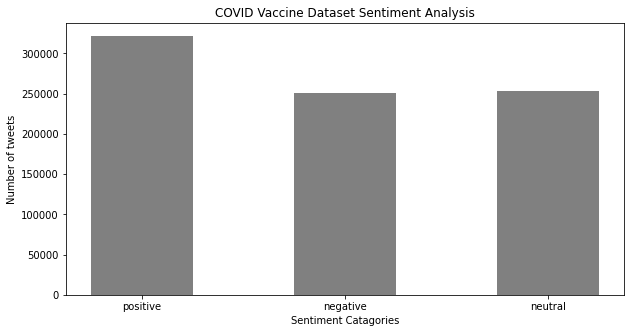

In [29]:
sent_dict = collections.Counter(tweet_sentiment_vader)

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(list(sent_dict.keys()), list(sent_dict.values()), color ='grey', width = 0.5)
 
plt.xlabel("Sentiment Catagories")
plt.ylabel("Number of tweets")
plt.title("COVID Vaccine Dataset Sentiment Analysis")
plt.show()

In [19]:
# Color Scheme for word cloud
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

In [27]:
# Function to create word cloud
def createWordCloud(processed_tweets_vaccine, tweet_sentiment_vader, sentiment, color_func):
  tweet_indices = np.where(np.array(tweet_sentiment_vader) == sentiment)
  tweets = np.array(processed_tweets_vaccine)[np.array(tweet_indices).astype(int)]

  word_cloud_string = " ".join(list(tweets[0]))

  wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(word_cloud_string)

  # Display the generated image:
  plt.figure(figsize = (10, 10), facecolor = None)
  plt.imshow(wordcloud.recolor(color_func=color_func, random_state=3), interpolation='bilinear')
  plt.axis("off")
  plt.show()

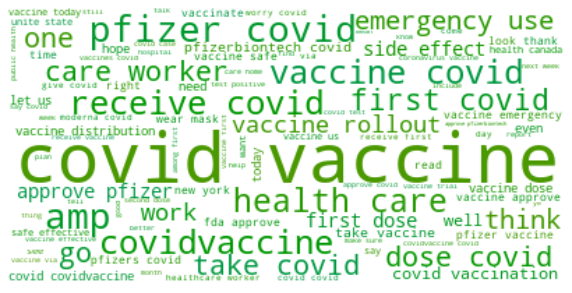

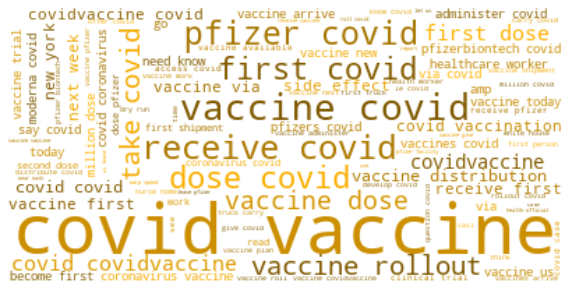

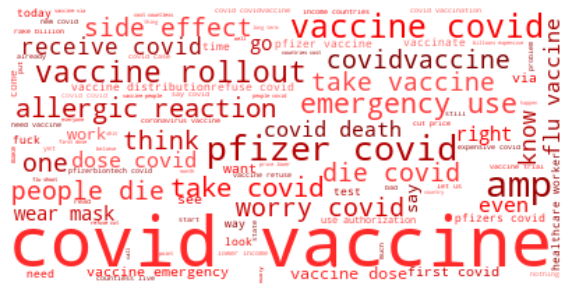

In [31]:
# Word Cloud for positive word
createWordCloud(processed_tweets_vaccine, tweet_sentiment_vader, "positive", green_color_func)

# Word Cloud for neutral word
createWordCloud(processed_tweets_vaccine, tweet_sentiment_vader, "neutral", yellow_color_func)

# Word Cloud for negative word
createWordCloud(processed_tweets_vaccine, tweet_sentiment_vader, "negative", red_color_func)
